In [1]:
from common import *
from pandas.api.types import CategoricalDtype
from numba import njit
from helper.bisect import bisect_left as binary_search

from sklearn.preprocessing import QuantileTransformer as QT
from scipy.stats import norm
ppf = norm.ppf

In [2]:
from given import *


# ------------------------------> looking at `W`

In [3]:
#pd.to_pickle((F,P), '/big/data/saves/train_5searchbase.32.pkl')
F,P = pd.read_pickle('/big/data/saves/train_5fixedsince+1.32.pkl')

### stock subsets

In [4]:
Mt = M[M.time>=train_start_time]

In [5]:
# # already in given.ipynb
# inUniCount = Mt.groupby('assetCodeId').universe.sum()
# stocksInUni = (inUniCount != 0).pipe(lambda x: x.index[x])
# assert stocksInUni.is_monotonic
# xStocksInUni = set(stocksInUni) #EDITCELL

In [6]:
W = O()
W.oo = M[['time','assetCodeId','oo']].pivot('time','assetCodeId').oo
W.aoo = M[['time','assetCodeId','aoo']].pivot('time','assetCodeId').aoo
W.ooTEN = M[['time','assetCodeId','ooTEN']].pivot('time','assetCodeId').ooTEN
W.aooTEN = M[['time','assetCodeId','aooTEN']].pivot('time','assetCodeId').aooTEN
# W.oo20 = W.y10 + W.y10.shift(10)
# W.aoo20 = W.ay10 + W.ay10.shift(10)
W.u = M[['time','assetCodeId','universe']].pivot('time','assetCodeId').universe.fillna(0).astype(int)
for c in W:
    W[c] = W[c][stocksInUni]
    W[c] = W[c][W[c].index>=train_start_time]

In [7]:
C = O()
# C.oo = W.oo.corr()
C.aoo = W.aoo.corr()
# C.ooTEN = W.ooTEN.corr()
C.aooTEN = W.aooTEN.corr()
C.u = W.u.T @ W.u

#### start here

In [8]:
@njit
def offdiag_items(ix, x, y):
    m, n = x.shape
    assert (m, n) == y.shape
    assert m == n
    assert (m,) == ix.shape
    t = (n**2-n) // 2
    I = np.full(t, -1, dtype=np.int64)
    J = np.full(t, -1, dtype=np.int64)
    X = np.full(t, 0, dtype=x.dtype)
    Y = np.full(t, 0, dtype=y.dtype)
    k = -1
    for i in range(m):
        for j in range(i+1, n):
            k += 1
            I[k] = ix[i]
            J[k] = ix[j]
            X[k] = x[i,j]
            Y[k] = y[i,j]
    return I, J, X, Y

In [9]:
D = O()
# D.v1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y1.index.values, C.y1.values, C.u.values))))
D.av1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.aoo.index.values, C.aoo.values, C.u.values))))
# D.v10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y10.index.values, C.y10.values, C.u.values))))
D.av10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.aooTEN.index.values, C.aooTEN.values, C.u.values))))
for c in ['av1','av10']:
    D[c] = D[c][D[c].Unic!=0]
    D[c].sort_values('Corr', ascending=False, inplace=True)

In [10]:
W = O() # gotta do this again to start from 2007 for the look-back window for correlation features
W.oo = M[['time','assetCodeId','oo']].pivot('time','assetCodeId').oo
W.aoo = M[['time','assetCodeId','aoo']].pivot('time','assetCodeId').aoo
W.ooTEN = M[['time','assetCodeId','ooTEN']].pivot('time','assetCodeId').ooTEN
W.aooTEN = M[['time','assetCodeId','aooTEN']].pivot('time','assetCodeId').aooTEN
# W.oo20 = W.y10 + W.y10.shift(10)
# W.aoo20 = W.ay10 + W.ay10.shift(10)
W.u = M[['time','assetCodeId','universe']].pivot('time','assetCodeId').universe.fillna(0).astype(int)
for c in W:
    W[c] = W[c][stocksInUni]

In [11]:
pd.to_pickle((O.py(W),O.py(C),O.py(D)), big_data/'pair/working_3novel.pkl')
#(W,C,D) = pd.read_pickle(big_data/'pair/working_3novel.pkl'); W, C, D = O(**W), O(**C), O(**D)

In [34]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

def dickey_matrix(stock_prices):
    """
    stock_prices: list time-series prices as np.array of the same length
    """
    n = len(stock_prices)
    result = np.zeros((n, n))
    model = LinearRegression()
    print('['+str(n*(n-1)//2)+']', end='')
    t = -1
    for i in range(n-1):
        for j in range(i+1, n):
            t += 1
            print_progress(t, 10)
            model.fit(stock_prices[i], stock_prices[j])
            epsilon = stock_prices[j] - model.predict(stock_prices[i])
#             print(model.coef_)
            result[i][j] = adfuller(epsilon.flatten())[1]
    return(result)

In [ ]:
dickey_matrix(W.aoo.fillna(0).T.values[..., None])

[2568511]0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.........2100.........2200.........2300.........2400.........2500.........2600.........2700.........2800.........2900.........3000.........3100.........3200.........3300.

In [16]:
@njit
def index_unique_pairs(A, B, values, repeat):
    assert len(A)==len(B)
    seen = [0] * len(values)
    ans = []
    for i, (a, b) in enumerate(zip(A, B)):
        ia = binary_search(values, a); ib = binary_search(values, b);
        if repeat==-1 or (seen[ia]<repeat and seen[ib]<repeat):
            seen[ia] += 1; seen[ib] += 1;
            ans.append(i)
    return ans

def make_unique_pairs(*, Dl, repeat=-1):
    ii = index_unique_pairs(Dl[0].values, Dl[1].values, sorted(set(Dl[0].values)|set(Dl[1].values)), repeat=repeat)
    return Dl.iloc[ii]

In [82]:
Dloo = make_unique_pairs(Dl=D.av10, repeat=-1)
Dl1 = make_unique_pairs(Dl=D.av10, repeat=1)
Dl2 = make_unique_pairs(Dl=D.av10, repeat=2)
Dl3 = make_unique_pairs(Dl=D.av10, repeat=3)
Dl4 = make_unique_pairs(Dl=D.av10, repeat=4)
Dl5 = make_unique_pairs(Dl=D.av10, repeat=5)
Dl10 = make_unique_pairs(Dl=D.av10, repeat=10)

In [83]:
shapes(Dl1, Dl2, Dl3, Dl4, Dl5, Dl10, Dloo, D.av10)

((1130, 4),
 (2258, 4),
 (3388, 4),
 (4520, 4),
 (5648, 4),
 (11285, 4),
 (1995076, 4),
 (1995076, 4))

<IPython.core.display.Javascript object>


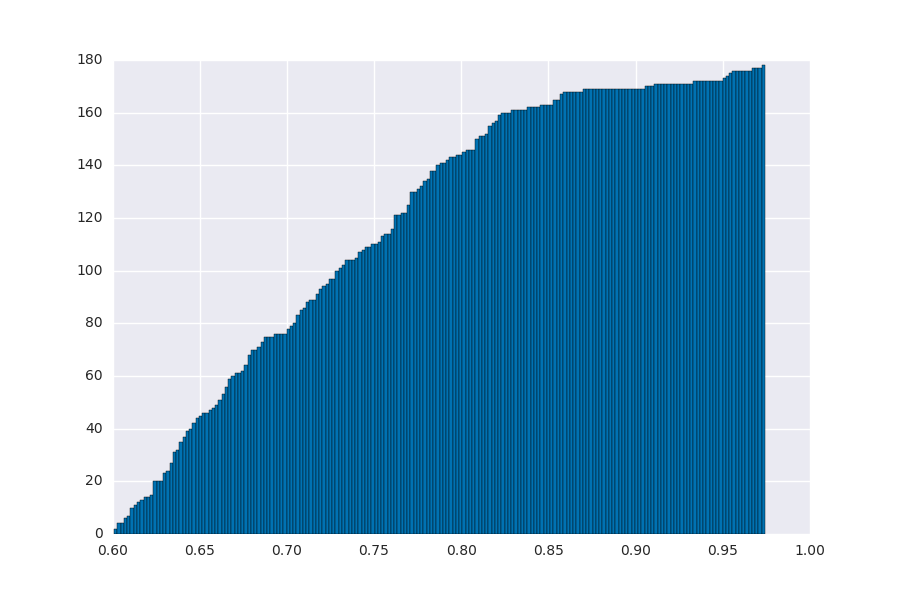

In [78]:
guy = Dl2
guy[(guy.Unic>=500)&(guy.Corr>=.6)].Corr.hist(bins=200, cumulative=True);

*just seeing*

In [11]:
guy = D.av10.copy()
guy[10] = guy[0].map(assetCodeMapName).map(assetNameIdAssign.series)
guy[11] = guy[1].map(assetCodeMapName).map(assetNameIdAssign.series)
guy[0] = guy[0].map(assetCodeIdAssign.series)
guy[1] = guy[1].map(assetCodeIdAssign.series)
guy = guy.reindex([0,1,10,11,'Corr','Unic'], axis=1)
guy[guy.Unic>=500].pipe(lambda x: x[(-1<=x.Corr)&(x.Corr<=1)]).reset_index(drop=True).tail(200);

In [12]:
guy[(guy[0]=='AAPL.O')&(guy[1]=='MSFT.O')]

,0,1,10,11,Corr,Unic
11111,AAPL.O,MSFT.O,Apple Inc,Microsoft Corp,0.099926,2014


<IPython.core.display.Javascript object>


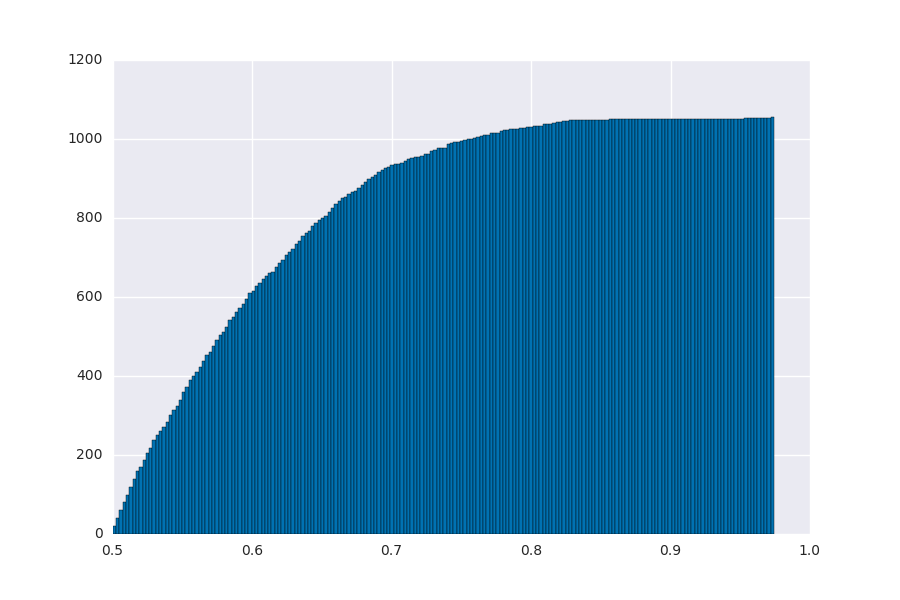

In [22]:
guy[(guy.Unic>=1500)&(guy.Corr>=.5)].Corr.hist(bins=200, cumulative=True);

#### making pair feature table

In [10]:
def make_CC_G_Q_from_Dl_F_P_W(*, Dl, F, P, W, hi=None, lo, roll_corr=list(product(['ay1','ay10','ay20'],[10,21,62,250]))):
    D = Dl
    allTime = pd.Series(P.time.unique())
    allTime.index = allTime
    
    if hi is None:
        hi = (1., 9999)
    D = D[(lo[0]<=D.Corr)&(D.Corr<=hi[0])&(lo[1]<=D.Unic)&(D.Unic<=hi[1])]
    hgt = sum(p[-1] for p in D.itertuples())
    CC = np.zeros((hgt,1+len(roll_corr)))
    G0, G1 = np.zeros((hgt,len(F.columns))), np.zeros((hgt,len(F.columns)))
    Q0, Q1 = [], []
    
    i = 0
    print(f'[{len(D)}]', end='')
    for ii, (_,a0,a1,corr,unic) in enumerate(D.itertuples()):
        print_progress(ii)
        
        in0, in1 = (F.assetCodeId==a0)&(P.universe!=0), (F.assetCodeId==a1)&(P.universe!=0)
        A0, A1 = F[in0], F[in1]
        B0, B1 = P[in0], P[in1]
        inTime = set(B0.time)&set(B1.time)
        tm0, tm1 = B0.time.isin(inTime), B1.time.isin(inTime)
        A0, A1 = A0[tm0], A1[tm1]
        B0, B1 = B0[tm0], B1[tm1]
        
        tm = allTime.isin(inTime).values
        def iter_roll_corr():
            for y, r in roll_corr:
                yield W[y][a0].rolling(window=r, min_periods=5).corr(W[y][a1])[tm] #TODO hard coded min_periods
        C = np.stack(chain(iter_roll_corr(),[np.ones_like(W[next(iter(W))].iloc[:,0][tm])*unic]), axis=1)
        
        G0[i:i+unic], G1[i:i+unic] = A0.values, A1.values
        Q0.append(B0); Q1.append(B1);
        CC[i:i+unic] = C
        
        i += unic
        
    Q0, Q1 = pd.concat(Q0, axis=0), pd.concat(Q1, axis=0)
    G0, G1 = pd.DataFrame(G0, index=Q0.index, columns=F.columns), pd.DataFrame(G1, index=Q1.index, columns=F.columns)
    C = pd.DataFrame(CC, columns=[f'__corr__{y}_{r}' for y,r in roll_corr]+['bothInUniCount'])
    return C, (G0,G1), (Q0,Q1)

In [14]:
%%time
CC, G, Q = make_CC_G_Q_from_Dl_F_P_W(Dl=D.av10,F=F,P=P,W=W,lo=(.6,500),hi=(.61,9999))

[99]0.........10.........20.........30.........40.........50.........60.........70.........80.........90........CPU times: user 23.1 s, sys: 480 ms, total: 23.6 s
Wall time: 23.5 s


*see scatter of pairs with corr whatever*

['QEP.N', 'LPI.N']
['QEP Resources Inc', 'Laredo Petroleum Inc']


<IPython.core.display.Javascript object>


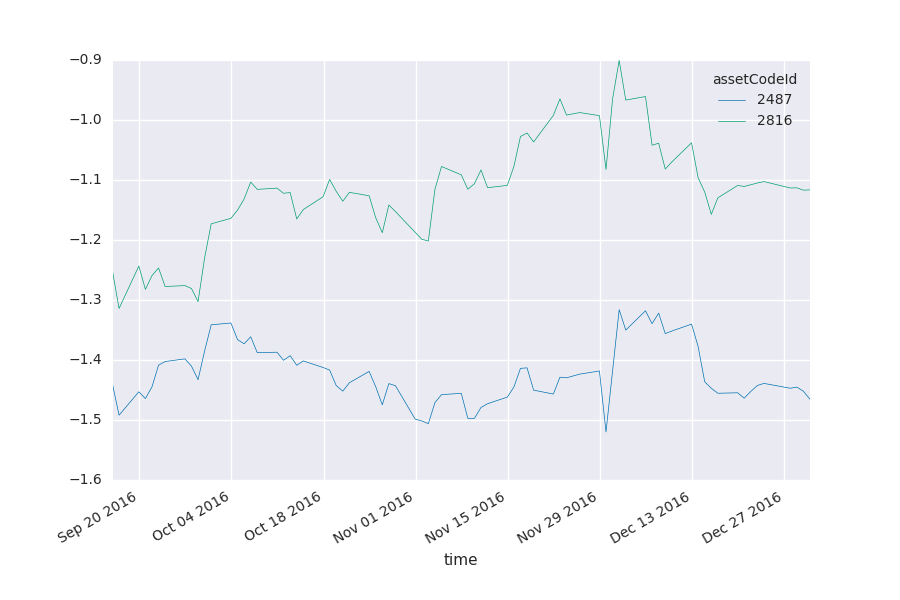

In [73]:
[[a0, a1]] = pd.DataFrame(np.stack([G[0].assetCodeId,G[1].assetCodeId],axis=1)).drop_duplicates().pipe(sample(1)).values
print(aId2Code([a0, a1]))
print(aCodeId2Name([a0, a1]))
#plt.scatter(W.ay1[a0],W.ay1[a1], s=1); plt.axes().set_aspect('equal');
#(W.ay1[a0]-W.ay1[a1]).hist(bins=80);
W.ay1[[a0,a1]].cumsum().tail(75).plot(linewidth=.5);

#### changing pair data into F and P structure

In [39]:
def make_FG_PQ(copy_filter, diff_filter, *, CC, G, Q):
    Gcols, Qcols = G[0].columns, Q[0].columns
    assert (Gcols==G[1].columns).all() and (Qcols==Q[1].columns).all()
    
    
    cop, dif = list(filter(copy_filter, Gcols)), list(filter(diff_filter, Gcols))
    G0, G1 = G[0][cop].values, G[1][cop].values
    H01 = G[0][dif].values - G[1][dif].values
    
    F01, F10 = np.concatenate([G0, G1, H01], axis=1), np.concatenate([G1, G0, -H01], axis=1)
    FG = np.concatenate([F01, F10], axis=0)
    
    FGcols = ['__0__'+c for c in cop] + ['__1__'+c for c in cop] + ['__0-1__'+c for c in dif]
    FG = pd.DataFrame(FG, columns=FGcols, copy=False)
    
    
    Q = Q[0].reset_index(drop=True), Q[1].reset_index(drop=True)
    assert(Q[0].time==Q[1].time).all()
    
    Q01 = pd.DataFrame(dict(time=Q[0].time, y=Q[0].y-Q[1].y,
                            **{f'__0__{c}': Q[0][c] for c in ['assetCode','assetName','universe']},
                            **{f'__1__{c}': Q[1][c] for c in ['assetCode','assetName','universe']}))
    Q10 = pd.DataFrame(dict(time=Q[1].time, y=Q[1].y-Q[0].y,
                            **{f'__0__{c}': Q[1][c] for c in ['assetCode','assetName','universe']},
                            **{f'__1__{c}': Q[0][c] for c in ['assetCode','assetName','universe']}))
    
    PQ = pd.concat([Q01, Q10], axis=0, ignore_index=True)
    
    
    PQ.sort_values('time', inplace=True)
    FG = FG.reindex(index=PQ.index, copy=False)
    
    FG.reset_index(drop=True, inplace=True)
    PQ.reset_index(drop=True, inplace=True)
    setup_P(F=None, P=PQ, vp=False, always=False)
    
    return FG, PQ

In [40]:
FG, PQ = make_FG_PQ(lambda x:x=='oo', lambda x:x=='oo', CC=CC,G=G,Q=Q)

In [41]:
P.head()

,time,assetCode,assetName,universe,returnsOpenNextMktres10,quarter,y,target,upDown,absVal,flat_weight,vp1_weight,vp5_weight,vp10_weight,always_weight
732812,2009-01-02 22:00:00+00:00,A.N,Agilent Technologies Inc,1.0,0.179633,2009.0,0.179633,True,1,0.179633,0.179633,0.008491,0.011776,0.015845,0.179633
732814,2009-01-02 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1.0,0.029782,2009.0,0.029782,True,1,0.029782,0.029782,0.000803,0.000745,0.001058,0.000000
732815,2009-01-02 22:00:00+00:00,AAPL.O,Apple Inc,1.0,-0.026166,2009.0,-0.026166,False,-1,0.026166,0.026166,0.060380,0.053807,0.055439,0.026166
732816,2009-01-02 22:00:00+00:00,AB.N,AllianceBernstein Holding LP,1.0,0.046983,2009.0,0.046983,True,1,0.046983,0.046983,0.000652,0.000559,0.000546,0.000000
732817,2009-01-02 22:00:00+00:00,ABB.N,ABB Ltd,1.0,-0.009046,2009.0,-0.009046,False,-1,0.009046,0.009046,0.000455,0.000386,0.000484,0.009046


In [42]:
FG.head()

,__0__oo,__1__oo,__0-1__oo
0,0.074108,0.054771,0.019337
1,0.024653,0.076540,-0.051887
2,0.031466,0.043561,-0.012095
3,0.074108,0.043561,0.030547
4,0.049331,0.034633,0.014698


In [43]:
PQ.tail()

,time,y,__0__assetCode,__0__assetName,__0__universe,__1__assetCode,__1__assetName,__1__universe,target,upDown,absVal,flat_weight
246901,2016-12-30 22:00:00+00:00,-0.067730,CFG.N,Citizens Financial Group Inc,1.0,MTU.N,Mitsubishi UFJ Financial Group Inc,1.0,False,-1,0.067730,0.067730
246902,2016-12-30 22:00:00+00:00,0.001357,POR.N,Portland General Electric Co,1.0,SO.N,Southern Co,1.0,True,1,0.001357,0.001357
246903,2016-12-30 22:00:00+00:00,0.013407,VOYA.N,Voya Financial Inc,1.0,PRU.N,Prudential Financial Inc,1.0,True,1,0.013407,0.013407
246904,2016-12-30 22:00:00+00:00,0.010756,CMS.N,CMS Energy Corp,1.0,AEP.N,American Electric Power Company Inc,1.0,True,1,0.010756,0.010756
246905,2016-12-30 22:00:00+00:00,0.017830,SNV.N,Synovus Financial Corp,1.0,WBS.N,Webster Financial Corp,1.0,True,1,0.017830,0.017830


#### old way of doing it

In [7]:
C.av1.head()

,0,1,Corr,Unic
0,0,1,0.145701,0
1,0,2,0.173884,1703
2,0,3,0.245055,2014
3,0,4,0.357883,2014
4,0,5,0.282466,2014


In [8]:
F['time'] = P.time
#F[['oo','time','assetCodeId']].head()#.pivot('time','assetCodeId')

In [7]:
def make_E_from_F_P(*, F, P):
    # add stuff to F I need
    F['time'] = P.time
    F['universe'] = P.universe.fillna(0) # not removed because need it for generating pair features
    F['assetCodeIdPivot'] = F.assetCodeId.astype(int)
    # the pivot ===============\___
    E = F.pivot('time','assetCodeIdPivot')
    # remove stuff I added to F
    del F['time'], F['universe'], F['assetCodeIdPivot']
    # end block
    
    E.columns = E.columns.swaplevel()
    E = E.sort_index(axis=1)
    E.columns.rename('assetCodeId', level=0, inplace=True)
    return E

In [28]:
E = make_E_from_F_P(F=F[['assetCodeId','oo','oo1','oo10','oo(15-5)','aoo1','aoo10','aoo(15-5)']], P=P)

In [8]:
#pd.to_pickle(E, big_data/'pair/E_2ONEorTEN.pkl')
E = pd.read_pickle(big_data/'pair/E_2ONEorTEN.pkl')

In [221]:
def make_C_D_L_from_E_Cv(*, E, Cv, cutoff, roll_corr=list(product(['oo','ooTEN'],[10,21,62,250]))):
    Cv = Cv[(Cv.Corr>=cutoff[0])&(Cv.Unic>=cutoff[1])]
    hgt = sum(p[-1] for p in Cv.itertuples())
    Fcolumns = [c for c in E.columns.levels[1] if c!='universe']
    D0, D1, L = np.zeros((hgt,len(Fcolumns))), np.zeros((hgt,len(Fcolumns))), np.zeros((hgt,1+len(roll_corr)))
    #^ -1 on len(Fcolumns) because I take away the 'universe' column
    
    i = 0
    for ii, (_,a0,a1,corr,unic) in enumerate(Cv.itertuples()):
        print_progress(ii)
        A0, A1 = E[a0], E[a1]
        inUniD = (A0.universe.fillna(0)!=0) & (A1.universe.fillna(0)!=0)
        assert inUniD.sum()==unic
        del A0['universe'], A1['universe']
        
        def iter_roll_corr():
            for y, r in roll_corr:
                if a0==1782 and a1==2523 and r==10:
                    BUG.x0 = A0[y]#[inUniD]
                    BUG.x1 = A1[y]#[inUniD]
                yield A0[y].rolling(window=r, min_periods=5).corr(A1[y]) #TODO hard coded min_periods
        B = np.stack(chain(iter_roll_corr(),[np.ones_like(A0.iloc[:,0])*unic]), axis=1)
        
        D0[i:i+unic], D1[i:i+unic] = A0[inUniD].values, A1[inUniD].values
        L[i:i+unic] = B[inUniD]
        
        i += unic
        
    D0 = pd.DataFrame(D0, columns=Fcolumns)
    D1 = pd.DataFrame(D1, columns=Fcolumns)
    L = pd.DataFrame(L, columns=[f'__corr__{y}_{r}' for y,r in roll_corr]+['bothInUniCount'])
    return (D0,D1), L

In [222]:
%%time
D, L = make_C_D_L_from_E_Cv(E=E,Cv=C.av1,cutoff=(.8,500))

0.........10.........20....CPU times: user 1.95 s, sys: 298 ms, total: 2.25 s
Wall time: 2.23 s


# ------------------------------> looking at `N`